In [3]:
import os 
import json
import pprint
import pandas as pd
from pandas import json_normalize
import numpy as np

from IPython.display import display
#from gnuplotlib import gp
import matplotlib.pyplot as plt
import autogpy
import seaborn as sns


C:\Users\larad\AppData\Local\Temp\ipykernel_27676\549442779.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [26]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)




def parseQlogFile(qlog_file_path, regex):
    f = open(qlog_file_path, 'r')
    qlog_data = f.read()
    f.close()

    records = qlog_data.strip().split(regex)
    parsedRecords = parseQlogDataRecords(records)
    #pprint.pprint(parsedRecords)
    #data_dict = createDictionary(parsedRecords)
    transport_records = [record for record in parsedRecords[1:] if 'packet_sent' in record["name"] or 'packet_received' in record["name"]]
    parameters_set_records = [record for record in parsedRecords[1:] if 'parameters_set' in record["name"]]
    #pprint.pprint(transport_records)
    #displayPandasTable(parsedRecords)
    #df = pd.DataFrame(parsedRecords[1:]).fillna('')
    #mux = pd.MultiIndex.from_tuples(r["data"].keys() for r in transport_records)
    #df = pd.DataFrame(list(r["data"].values() for r in transport_records), index=mux).fillna('')
    #display(df)
    handshake_time = getHandshakeTime(transport_records)
    error_reason = getError(transport_records)
    tls_established = getTLSInfo(parameters_set_records)
    
    return handshake_time, error_reason, tls_established


def getHandshakeTime(records):
    packet_types = {}
    handshake_end_time = 0
    initial_packet_time = records[0]["time"]

    # Get time of first data packet:
    for record in records:
        packet_type = record["data"]["header"]["packet_type"]
        if packet_type != "initial" and packet_type != "handshake":
            handshake_end_time = record["time"]
            break

    # Get number of different packet types
    for record in records:
        packet_type = record["data"]["header"]["packet_type"]
        
        if packet_type not in packet_types:
            packet_types[packet_type] = 1
        else:
            packet_types[packet_type] += 1
    
    if len(packet_types.keys()) == 1:
        #print("No connection was established.")
        return None
    else:
        #print("Transport Packet Types: ", packet_types)
        #print("Time to Complete Handshake: ", handshake_end_time - initial_packet_time, "ms")
        return handshake_end_time - initial_packet_time

def getError(records):
    error_reason = ""
    for record in records:
        if "frames" in record["data"]:
            for frame in record["data"]["frames"]:
                if frame["frame_type"] == "connection_close":
                    error_reason = frame["reason"]
                    break
            
    return error_reason

def getTLSInfo(records):
    tls_ciphers = []
    for record in records:
        if "tls_cipher" in record["data"]:
            tls_ciphers.append(record["data"]["tls_cipher"])
    return tls_ciphers

def parseQlogDataRecords(qlog_data):
   json_data = [json.loads(string.strip()) for string in qlog_data]
   return json_data

def createDictionary(parsed_data):
    data_dict = {}

    for data in parsed_data:
        if type(data) == dict:
            for key, value in data.items():
                if key not in data_dict:
                    data_dict[key] = [value]
                else:
                    if type(value) == dict:
                        data_dict[key].append(createDictionary(value))
                    else:
                        data_dict[key].append(value)
        else:
            return parsed_data

    
    #pprint.pprint(data_dict)
    return data_dict

def displayPandasTable(parsedRecords):

    flattened_header_data = createDictionary(parsedRecords[0])
    flattened_header_data2 = createDictionary(parsedRecords[1])
    flattened_data = createDictionary(parsedRecords[1:])

    #pprint.pprint(flattened_data)
            
    # Create DataFrame from flattened data
    #df = pd.DataFrame(parsedRecords)
    #df = pd.concat({k: pd.DataFrame(v).T for k, v in data_dict.items()}, axis=0)
    df1 = pd.DataFrame(flattened_header_data)
    df2 = pd.DataFrame(flattened_header_data2)
    df2 = pd.DataFrame(flattened_header_data2)
    #df = pd.DataFrame({k: [flattened_data.get(k, None)] for k in keys})
    df = pd.DataFrame(flattened_data)

    df = df.fillna('')
    # Display DataFrame
    #df = json_normalize(df)
    #df = pd.MultiIndex.from_frame(df)
    #df.to_flat_index()
    
    display(df1)
    display(df2)
    display(df)
    

def getMeanTime(times):
    return np.mean([time for time in times if time != None])

def generateHandshakeTimeDistribution(handshake_data):
    sns.set_style("white")

    urls, times = [], []
    max_time = 0
    none = 0
    for url,time in handshake_data.items():
        if time != None:
            urls.append(url)
            times.append(time)
            
            if time > max_time:
                max_time = time
        else:
            none += 1

    print(max_time)
    bins = int(max_time // 5)
    print(bins)

    sns.histplot(times, color="dodgerblue", bins=bins, kde=True) #log_scale=True

    plt.title('Distribution of Time to complete Handshake using QUIC')
    plt.xlabel('Handshake Time (ms)')
    plt.ylabel('Frequency') 
    
    plt.show()
    print("Number of no connection: ", none)
    #print(df.head())

def getTLSErrors(error_reasons):
    tls_errors = {}
    urls, errors = [], []
    for k, v in error_reasons.items():
        if v != '':
            urls.append(k)
            errors.append(v)
            if v in tls_errors:
                tls_errors[v].append(k)
            else:
                tls_errors[v] = [k]
    
    #df = pd.DataFrame(data=zip(urls, errors), columns=["Urls", "Error Message"])
    #display(df)
    for error in tls_errors:
        print("\nNumber of errors with message", error, ": ", len(tls_errors[error]))
        print((len(tls_errors[error])/len(errors)) * 100, "% of all errors")


def getTLSEstablishedInfo(tls_established):
    urls, tls_cipher = [], []
    tls_count = 0
    for k, v in tls_established.items():
        urls.append(k)
        tls_cipher.append(v)
        for cipher in v:
            if cipher != None:
                tls_count += 1
    
    #df = pd.DataFrame(data=zip(urls, tls_cipher), columns=["Urls", "TLS Cipher"])
    #display(df)
    print("Number of established TLS ciphers: ", tls_count, " aka ", (tls_count/917) * 100, "%")

477.28380699999997
95


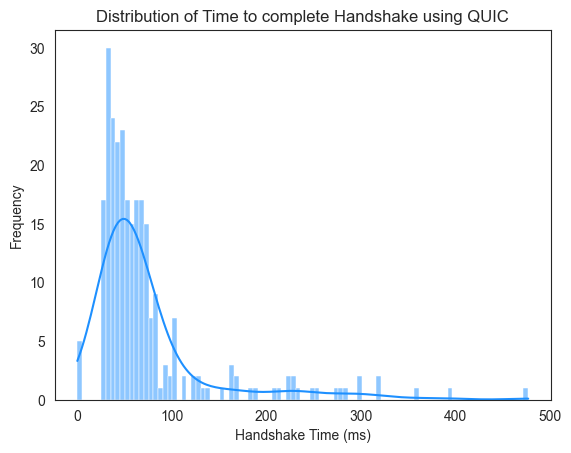

Number of no connection:  651

Number of errors with message kthxbye :  257
61.48325358851675 % of all errors

Number of errors with message 200:TLS handshake failure (ENCRYPTION_INITIAL) 80: internal error :  155
37.08133971291866 % of all errors

Number of errors with message handshake failed :  2
0.4784688995215311 % of all errors

Number of errors with message 28:Reject connection :  1
0.23923444976076555 % of all errors

Number of errors with message TLS alert 80 :  1
0.23923444976076555 % of all errors

Number of errors with message 28:TLS handshake failure (ENCRYPTION_INITIAL) 40: handshake failure :  2
0.4784688995215311 % of all errors
Number of established TLS ciphers:  1178  aka  128.46237731733916 %


In [27]:

regex = chr(30)
# Folder Path 
path = "C:/Users/larad/Documents/l4project/data/packetCapture_home/quic"
# Change the directory 
os.chdir(path) 
ctr = 0

handshake_times = {}
error_reasons = {}
tls_established = {}
#qlog_files=0
# iterate through all file 
for folder in os.listdir(): 
    #print("inside " + folder)
    quic_folder_path = f"{path}/{folder}"
    os.chdir(quic_folder_path)
    
    for file in os.listdir():
        #print("inside for")
        # Check whether file is in sqlog format or not 
        if file.endswith(".sqlog"): 
            handshake_times[folder], error_reasons[folder], tls_established[folder] = parseQlogFile(f"{quic_folder_path}/{file}", regex)
            #print("file "+qlog_file_path+" has been opened")
            #ctr += 1
            #qlog_files += 1

    
#print("Average time to complete handshake: ", getMeanTime(handshake_times), "ms")
#generateHandshakeTimeDistribution(handshake_times)
generateHandshakeTimeDistribution(handshake_times)
getTLSErrors(error_reasons)
getTLSEstablishedInfo(tls_established)


In [ ]:


"""
TLS:

parameters_set
key_updated & key_discarded : tls can trigger
crypto_error

packet_received, raw, frames -> [{frame_type: "connection_close", "reason": "CONTAINS TLS"}]
handshake_failure: Indicates that the sender was unable to negotiate an acceptable set of security parameters 
given the options available. This is a fatal error.

internal_error: An internal error unrelated to the peer or the correctness of the protocol makes it impossible 
to continue, such as a memory allocation failure. The error is not related to protocol. 
This message is always fatal.

"""